## Analisis dan klasifikasi TIngkat kelayakan pendapatan pekerja menggunakan metode naive bayes dan decision tree


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


**Noted**

1. gk = garis kemiskinan
2. peng = dataset Rata-Rata Pengeluaran Per Kapita dengan disagregasi Provinsi, Tahun, Jenis Pengeluaran, dan Daerah Tempat Tinggal.
3. ump = dataset Upah Minimum Provinsi (UMP) dengan disagregasi Provinsi dan Tahun
4. upah = dataset Rata-Rata Upah Pekerja Per Jam dengan disagregasi Provinsi dan Tahun


In [7]:
data_gk = pd.read_csv('Cache/gk.df.csv')
data_peng = pd.read_csv('Cache/peng.df.csv')
data_ump = pd.read_csv('Cache/ump.df.csv')
data_upah = pd.read_csv('Cache/upah.df.csv')



In [8]:
data_gk.head()


,provinsi,jenis,daerah,tahun,periode,gk
0,ACEH,MAKANAN,PERKOTAAN,2015,MARET,293697.0
1,ACEH,MAKANAN,PERKOTAAN,2015,SEPTEMBER,302128.0
2,ACEH,MAKANAN,PERKOTAAN,2016,MARET,306243.0
3,ACEH,MAKANAN,PERKOTAAN,2016,SEPTEMBER,319768.0
4,ACEH,MAKANAN,PERDESAAN,2015,MARET,297479.0


In [9]:
data_peng.head()


,provinsi,daerah,jenis,tahun,peng
0,ACEH,PERDESAAN,MAKANAN,2007,195176.0
1,ACEH,PERDESAAN,MAKANAN,2008,218781.0
2,ACEH,PERDESAAN,MAKANAN,2009,247427.0
3,ACEH,PERDESAAN,MAKANAN,2010,275749.0
4,ACEH,PERDESAAN,MAKANAN,2011,308000.0


In [10]:
data_ump.head()


,provinsi,tahun,ump
0,ACEH,2002,330000.0
1,ACEH,2003,425000.0
2,ACEH,2004,550000.0
3,ACEH,2005,620000.0
4,ACEH,2006,820000.0


In [11]:
data_upah.head()


,provinsi,tahun,upah
0,ACEH,2015,11226
1,ACEH,2016,13627
2,ACEH,2017,14809
3,ACEH,2018,13814
4,ACEH,2019,15065


### Preprocessing


In [12]:
# menyatukan data berdasarkan kesamaan kolom
prep1 = pd.merge(data_gk, data_peng, 
                 on=['provinsi', 'jenis', 'daerah', 'tahun'])

prep2 = pd.merge(prep1, data_ump, 
                 on=['provinsi', 'tahun'])

data_prep = pd.merge(prep2, data_upah, 
                 on=['provinsi', 'tahun'])



In [13]:
data_prep.head()


,provinsi,jenis,daerah,tahun,periode,gk,peng,ump,upah
0,ACEH,MAKANAN,PERKOTAAN,2015,MARET,293697.0,466355.0,1900000.0,11226
1,ACEH,MAKANAN,PERKOTAAN,2015,SEPTEMBER,302128.0,466355.0,1900000.0,11226
2,ACEH,MAKANAN,PERKOTAAN,2016,MARET,306243.0,548853.0,2118500.0,13627
3,ACEH,MAKANAN,PERKOTAAN,2016,SEPTEMBER,319768.0,548853.0,2118500.0,13627
4,ACEH,MAKANAN,PERDESAAN,2015,MARET,297479.0,395136.0,1900000.0,11226


In [14]:
data_prep=data_prep.rename(columns={'gk':'garis-kemiskinan-perkapita', 'peng':'pengeluaran-perkapita', 'ump':'upah-minimum-provinsi', 'upah':'upah-pekerja-perjam'})


In [15]:
data_prep.head()


,provinsi,jenis,daerah,tahun,periode,garis-kemiskinan-perkapita,pengeluaran-perkapita,upah-minimum-provinsi,upah-pekerja-perjam
0,ACEH,MAKANAN,PERKOTAAN,2015,MARET,293697.0,466355.0,1900000.0,11226
1,ACEH,MAKANAN,PERKOTAAN,2015,SEPTEMBER,302128.0,466355.0,1900000.0,11226
2,ACEH,MAKANAN,PERKOTAAN,2016,MARET,306243.0,548853.0,2118500.0,13627
3,ACEH,MAKANAN,PERKOTAAN,2016,SEPTEMBER,319768.0,548853.0,2118500.0,13627
4,ACEH,MAKANAN,PERDESAAN,2015,MARET,297479.0,395136.0,1900000.0,11226


In [16]:
data_prep.describe()


,tahun,garis-kemiskinan-perkapita,pengeluaran-perkapita,upah-minimum-provinsi,upah-pekerja-perjam
count,5040.000000,4992.000000,4.992000e+03,5.040000e+03,5040.000000
mean,2018.500000,303480.478966,7.596263e+05,2.311369e+06,16621.010714
std,2.291515,161774.812856,3.547308e+05,6.021348e+05,4364.422282
min,2015.000000,48561.000000,1.760280e+05,9.100000e+05,8525.000000
25%,2016.750000,138142.750000,5.010822e+05,1.877250e+06,13468.750000
50%,2018.500000,314506.000000,6.595245e+05,2.268432e+06,15845.000000
75%,2020.250000,413791.750000,9.457802e+05,2.688292e+06,18634.750000
max,2022.000000,872843.000000,2.525347e+06,4.641854e+06,32685.000000


In [17]:
# Asumsikan 'provinsi' adalah nama kolom yang berisi nilai 'aceh'
data_prep.loc[data_prep['tahun'] == 2015].head()


,provinsi,jenis,daerah,tahun,periode,garis-kemiskinan-perkapita,pengeluaran-perkapita,upah-minimum-provinsi,upah-pekerja-perjam
0,ACEH,MAKANAN,PERKOTAAN,2015,MARET,293697.0,466355.0,1900000.0,11226
1,ACEH,MAKANAN,PERKOTAAN,2015,SEPTEMBER,302128.0,466355.0,1900000.0,11226
4,ACEH,MAKANAN,PERDESAAN,2015,MARET,297479.0,395136.0,1900000.0,11226
5,ACEH,MAKANAN,PERDESAAN,2015,SEPTEMBER,306737.0,395136.0,1900000.0,11226
8,ACEH,MAKANAN,PERDESAANPERKOTAAN,2015,MARET,296406.0,415354.0,1900000.0,11226


In [18]:
def jenis_kebutuhan(x):
      if x == "MAKANAN":
            return 0
      elif x == "NONMAKANAN":
            return 1
      else:
            return 2

data_prep['jenis_prep'] = data_prep['jenis'].apply(jenis_kebutuhan)



In [19]:
def daerah_tempat_tinggal(x):
      if x == "PERDESAAN":
            return 0
      elif x == "PERKOTAAN":
            return 1
      else:
            return 2

data_prep['daerah_prep'] = data_prep['daerah'].apply(daerah_tempat_tinggal)

**Noted:**
1. jenis_prep = 0 (MAKANAN),1 (NONMAKANAN),2 (TOTAL)
2. daerah_prep = 0 (PERDESAAN),1 (PERKOTAAN),2 (TOTAL)


In [20]:
prep = data_prep.filter(['provinsi','tahun', 'jenis_prep', 'daerah_prep', 'garis-kemiskinan-perkapita', 'pengeluaran-perkapita', 'upah-minimum-provinsi', 'upah-pekerja-perjam'])


In [21]:
prep.head()


,provinsi,tahun,jenis_prep,daerah_prep,garis-kemiskinan-perkapita,pengeluaran-perkapita,upah-minimum-provinsi,upah-pekerja-perjam
0,ACEH,2015,0,1,293697.0,466355.0,1900000.0,11226
1,ACEH,2015,0,1,302128.0,466355.0,1900000.0,11226
2,ACEH,2016,0,1,306243.0,548853.0,2118500.0,13627
3,ACEH,2016,0,1,319768.0,548853.0,2118500.0,13627
4,ACEH,2015,0,0,297479.0,395136.0,1900000.0,11226


In [22]:
# cm = prep.drop(columns=['provinsi', 'daerah_prep','jenis_prep'])
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm.corr(), annot=True, fmt='g', cmap='Blues', cbar=False)
# plt.title('Confusion Matrix')
# plt.show()




dari hasil visualisasi menggunakan confusion matrix diatas, dapat dilihat beberapa korelasi yang terjadi pada dataset ini, yaitu:
1. garis-kemiskinan-perkapita memiliki korelasi yang cukuptinggi dengan pengeluaran-perkapita sebesar 0.721195. begitupun sebaliknya, pengeluaran-perkapita memiliki korelasi yang cukup tinggi dengan garis-kemiskinan-perkapita sebesar 0.721195
2. upah-minimum-provinsi memiliki korelasi yang cukup tinggi dengan upah-pekerja-perjam sebesar 0.6966 begitupun sebaliknya, pengeluaran-perkapita memiliki korelasi yang cukup tinggi dengan upah-pekerja-perjam sebesar 0.6966

selain itu terdapat juga hubungan antar label yang memiliki nilai korelasi yang rendah.


In [23]:
# Fungsi untuk menghitung rata-rata per provinsi
def hitung_rata_rata_provinsi(prep):
    return prep.groupby('provinsi').mean().reset_index()

In [24]:
# membuat kolom target berdasarkan kolom yang ada
# Fungsi untuk menghitung skor
def hitung_skor(row):
    skor = 0
    if row['gaji'] > row['garis-kemiskinan-perkapita']:
        skor += 1
    if row['gaji'] > row['upah-minimum-provinsi']:
        skor += 1
    if row['pengeluaran-perkapita'] / row['gaji'] < 0.7:
        skor += 1
    return skor 



**Noted** langkah pertama dalam membuat kolom target yaitu menghitung skor dimana diagi menjadi 3 kriteria
- kriteria a: jika gaji lebih besar dari garis kemisikinan maka mendapatkan skor 1, tetapi jika tidak maka mendapatkan skor 0
- kriteris b: jika gaji lebih besar dari upah minimum provinsi maka mendapatkan skor 1, jika tidak maka mendapatkan  skor 0
- kriteria c: jika hasil dari pengeluaran perkapita/gaji kecil dari margin batas keuangan 0.7 maka mendapatkan skor 1, jika tidak mendapatkan skor 0

penentuan margin berdasarkan prinsip keuangan yaitu 50/30/20:
- 50% merupakan kebutuhan pokok atau wajib
- 30% untuk memenuhi keinginan sperti berbelanja barang yang di inginkan
- 20% untuk investasi

tetapi pada kasus ini saya menetapkan margin sebesar 70% dimana 10% digunakan untuk dana tidak terduga.

In [25]:
def prep_target(x):
      if x == 3:
            return 3
      elif x == 2:
            return 2
      elif x == 1:
            return 1
      else:
            return 0

In [26]:
# prep = hitung_rata_rata_provinsi(prep)
# Hitung gaji per jam (asumsikan 20 hari kerja per bulan, 8 jam per hari), dimana terdiri dari hari libur sabtu dan minggu selama 4 minggu
prep['gaji'] = prep['upah-pekerja-perjam'] * 8 * 20

# Hitung skor
prep['total_skor'] = prep.apply(hitung_skor, axis=1)

# Tentukan target
prep['target'] = prep['total_skor'].apply(prep_target)

In [27]:
prep.head()

,provinsi,tahun,jenis_prep,daerah_prep,garis-kemiskinan-perkapita,pengeluaran-perkapita,upah-minimum-provinsi,upah-pekerja-perjam,gaji,total_skor,target
0,ACEH,2015,0,1,293697.0,466355.0,1900000.0,11226,1796160,2,2
1,ACEH,2015,0,1,302128.0,466355.0,1900000.0,11226,1796160,2,2
2,ACEH,2016,0,1,306243.0,548853.0,2118500.0,13627,2180320,3,3
3,ACEH,2016,0,1,319768.0,548853.0,2118500.0,13627,2180320,3,3
4,ACEH,2015,0,0,297479.0,395136.0,1900000.0,11226,1796160,2,2


In [30]:
# Mengambil kolom yang akan digunakan untuk proses klasifikasi
df = prep.filter(["tahun", "jenis_prep", "daerah_prep", "garis-kemiskinan-perkapita", "pengeluaran-perkapita", "upah-minimum-provinsi", "upah-pekerja-perjam", "gaji", "target"])

In [32]:
df.head()

,tahun,jenis_prep,daerah_prep,garis-kemiskinan-perkapita,pengeluaran-perkapita,upah-minimum-provinsi,upah-pekerja-perjam,gaji,target
0,2015,0,1,293697.0,466355.0,1900000.0,11226,1796160,2
1,2015,0,1,302128.0,466355.0,1900000.0,11226,1796160,2
2,2016,0,1,306243.0,548853.0,2118500.0,13627,2180320,3
3,2016,0,1,319768.0,548853.0,2118500.0,13627,2180320,3
4,2015,0,0,297479.0,395136.0,1900000.0,11226,1796160,2


In [39]:
cm = df.drop(columns=["tahun", "jenis_prep", "daerah_prep"])

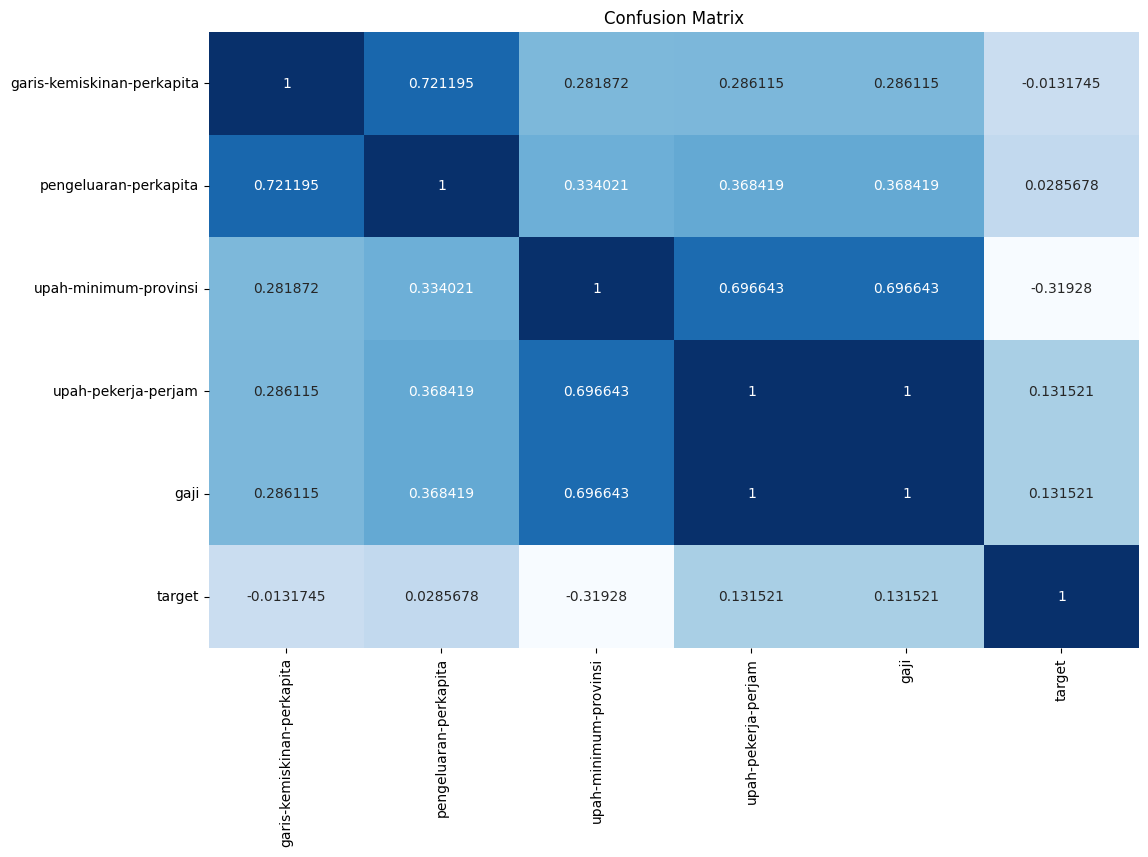

In [42]:
plt.figure(figsize=(12, 8))
sns.heatmap(cm.corr(), annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.show()

In [44]:
# # menyimpan data yang telah diolah
# df.to_csv('Data/data_kelayakan_gaji.csv', index=False)

**Noted:**

penjelasan mengenai data (lengkap):
1. garis-kemiskinan-perkapita = batas minimum kebutuhan perbulannya
2. penegluaran-perkapita = dataset Rata-Rata Pengeluaran Per Kapita dengan disagregasi Provinsi, Tahun, Jenis Pengeluaran, dan Daerah Tempat Tinggal.
3. upah-minimum-perkapita = dataset Upah Minimum Provinsi (UMP) dengan disagregasi Provinsi dan Tahun
4. upah-pekerja-perjam = dataset Rata-Rata Upah Pekerja Per Jam dengan disagregasi Provinsi dan Tahun
5. jenis-prep = 0 (MAKANAN),1 (NONMAKANAN),2 (TOTAL)
6. daerah_prep = 0 (PERDESAAN),1 (PERKOTAAN),2 (TOTAL)
7. gaji: didapatkan dari proses perhitungan total gaji selama sebulan dengan rumus (gaji perjam * lama hari bekerja dalam sebulan * lama jam bekerja selama satu hari)
8.  target: 3 (Sangat Layak), 2 (layak), 1 (cukup), 0 (tidak layak)

### Visualisasi data